In [644]:
import pandas as pd
import numpy as np
import datetime
import cvxpy as cp
import networkx as nx
import math
import matplotlib.pyplot as plt


In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')

#df = pd.read_csv(infile, parse_dates={'datetime': ['Date', 'Time']}, date_parser=dateparse)

df = pd.read_csv("fixtures-results.csv", parse_dates={'datetime': ['Date', 'Time']}, date_parser=dateparse)

/Users/maloferriol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [3]:
df = df.where(df['Status'] != 'P').dropna(subset=["ID"])
df.tail(10)

,datetime,ID,Status,Home Team,H HT Score,H Score,A Score,A HT Score,Away Team,Attendance
269,2020-03-01 14:00:00,331836.0,FT,Nantes,0.0,0.0,1.0,0.0,Lille,20704.0
270,2020-03-06 20:00:00,337996.0,FT,Marseille,1.0,2.0,2.0,0.0,Amiens,NaN
271,2020-03-07 19:00:00,140371.0,FT,Angers,0.0,2.0,0.0,0.0,Nantes,12132.0
272,2020-03-07 19:00:00,140372.0,FT,Dijon,1.0,2.0,1.0,1.0,Toulouse,12549.0
273,2020-03-07 19:00:00,140375.0,FT,Metz,1.0,2.0,1.0,0.0,Nîmes,14797.0
274,2020-03-07 19:00:00,140376.0,FT,Nice,0.0,2.0,1.0,1.0,Monaco,NaN
275,2020-03-07 19:00:00,140377.0,FT,Reims,1.0,1.0,0.0,0.0,Brest,11062.0
276,2020-03-08 20:00:00,337999.0,FT,Lille,1.0,1.0,0.0,0.0,Lyon,NaN
277,2020-03-08 16:00:00,337998.0,FT,Rennes,2.0,5.0,0.0,0.0,Montpellier,24818.0
278,2020-03-08 14:00:00,337997.0,FT,Saint Étienne,0.0,1.0,1.0,0.0,Bordeaux,24912.0


In [4]:
new_df = df[df["datetime"] < datetime.datetime(2020,3,2)]
new_df.describe().loc[['count']]

,ID,H HT Score,H Score,A Score,A HT Score,Attendance
count,270.0,270.0,270.0,270.0,270.0,212.0


In [5]:
list(new_df.columns)

['datetime',
 'ID',
 'Status',
 'Home Team',
 'H HT Score',
 'H Score',
 'A Score',
 'A HT Score',
 'Away Team',
 'Attendance']

In [7]:
def victory(row):
    hw = row[5] > row[6]
    d  = row[5] == row[6]
    aw = not(hw or d)

    return int(hw), int(aw), int(d)

In [8]:
new_df[["home_win",
       "away_win", 
       "draw"]] = df.apply(lambda row : victory(row), 
                               axis='columns', 
                               result_type='expand', raw=True) 

/Users/maloferriol/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [9]:
new_df = new_df.drop(columns=['datetime','ID','Status', 'H HT Score', 'A HT Score', 'Attendance'])

In [10]:
new_df['home_win'].value_counts()

0    143
1    127
Name: home_win, dtype: int64

In [11]:
teams = new_df["Home Team"].unique()

def norm(row):
    a = row.sum()
    if (a == 0):
        return 0
    else:
        return row / float(row.sum())
        

In [12]:
df_home_win = pd.pivot_table(new_df, 
                             values='home_win', 
                             index=["Home Team"],
                             columns=["Away Team"], 
                             aggfunc=np.sum).fillna(0)#.apply(lambda x: norm(x), axis=1)

df_away_win = pd.pivot_table(new_df, 
                             values='away_win',
                             index=["Away Team"],
                             columns=["Home Team"],
                             aggfunc=np.sum).fillna(0)#.apply(lambda x: norm(x), axis=1)
df_win = df_home_win + df_away_win
#df_win = df_win#.apply(lambda x: x / float(x.sum()), axis=0)#.round(2)


In [13]:
df_home_draw = pd.pivot_table(new_df, 
                              values='draw', 
                              index=["Home Team"],
                              columns=["Away Team"], 
                              aggfunc=np.sum).fillna(0).apply(lambda x:norm(x), axis=0)
df_away_draw = pd.pivot_table(new_df, 
                              values='draw',
                              index=["Away Team"],
                              columns=["Home Team"],
                              aggfunc=np.sum).fillna(0).apply(lambda x: norm(x), axis=0)
df_draw = df_home_draw + df_away_draw
df_draw = df_draw.apply(lambda x: x / float(x.sum()), axis=1).round(2)#.to_numpy()


In [14]:
df_home_score = pd.pivot_table(new_df, 
                               values='H Score', 
                               index=["Home Team"],
                               columns=["Away Team"],
                               aggfunc=np.sum).fillna(0).apply(lambda x: norm(x), axis=0)
df_away_score = pd.pivot_table(new_df, 
                               values='A Score', 
                               index=["Away Team"],
                               columns=["Home Team"], 
                               aggfunc=np.sum).fillna(0).apply(lambda x: norm(x), axis=0)
df_score = df_home_score + df_away_score
df_score = df_score#.apply( lambda x: x / float(x.sum()), axis=0)#.to_numpy()


In [15]:
df_home_score["Amiens"].sum()

0.9999999999999999

In [16]:
df_win.loc['Marseille',:].sum()

16.0

In [347]:
df_win

Away Team,Amiens,Angers,Bordeaux,Brest,Dijon,Lille,Lyon,Marseille,Metz,Monaco,Montpellier,Nantes,Nice,Nîmes,Paris St Germain,Reims,Rennes,Saint Étienne,Strasbourg,Toulouse
Home Team,,,,,,,,,,,,,,,,,,,,
Amiens,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angers,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
Bordeaux,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
Brest,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
Dijon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
Lille,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0
Lyon,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0
Marseille,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,1.0,2.0
Metz,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0


In [593]:
#test_np = df_score.to_numpy() #
home_score_np = np.transpose( gph )
#away_score_np = np.transpose( df_away_score.to_numpy() )

In [594]:
home_score_P = [home_score_np[i].tolist() for i in range(len(home_score_np))]
home_score_P = np.array(home_score_P)

#away_score_P = [away_score_np[i].tolist() for i in range(len(away_score_np))]
#away_score_P = np.array(away_score_P)
m,n = np.shape(home_score_P)

ValueError: too many values to unpack (expected 2)

In [631]:
def norm(gph):
    gph = np.asarray(gph)
    m, n = gph.shape
    for i in range (m):
        print(gph[i].sum())
        for j in range(n):
            gph[i][j]/ (gph[i].sum())
    return gph


gph = np.asarray(gph)
gph = gph / np.linalg.norm(gph, axis=-1)[:, np.newaxis]

print(gph.shape)
x_1 = cp.Variable(20)
objective_1 = cp.Minimize(cp.sum(cp.abs(x_1)))
constraints_1 = [np.transpose( gph ) @ x_1 == x_1, sum(x_1) == 1, x_1 >= 0]

#x_2 = cp.Variable(n)
#objective_2 = cp.Minimize(cp.sum(cp.abs(x_2)))
#constraints_2 = [np.transpose(away_score_P) @ x_2 == x_2, sum(x_2) == 1, x_2 >= 0]

(20, 20)


In [632]:
type(gph)
A = np.asarray(gph)
A.shape

(20, 20)

In [633]:
prob_1 = cp.Problem(objective_1, constraints_1)
#prob_2 = cp.Problem(objective_2, constraints_2)

result_1 = prob_1.solve()
#result_2 = prob_2.solve()

In [634]:
print(result_1)

inf


In [635]:
page_rank_1 = x_1.value 
#page_rank_2 = x_2.value 
page_rank   = page_rank_1 #+ page_rank_1

In [636]:
print("Page rank of each page\n")
sorted_list = sorted(range(len(page_rank)), key=lambda k: page_rank[k])
for i in sorted_list[::-1]:
    print(teams[i], ": Rank = ", page_rank[i])

Page rank of each page



TypeError: object of type 'NoneType' has no len()

In [592]:
#P_link = np.transpose( df_home_score.to_numpy() )# + df_away_win.to_numpy()
P_link = np.transpose( gph )

alpha = 0.85
print(np.shape(P_s))
m,n = np.shape(P_stochastic)
e = np.ones((n,1))

P = alpha* P_stochastic + (1-alpha) * e @ e.T/n

x = cp.Variable(n)
objective = cp.Minimize(cp.sum(cp.abs(x)))
constraints = [np.transpose(P) @ x == x, sum(x) == 1, x >= 0]

prob = cp.Problem(objective, constraints)
result = prob.solve()
print("result", result)

page_rank_1 = x.value


print("Page rank of each page\n")
sorted_list = sorted(range(len(page_rank_1)), key=lambda k: page_rank_1[k])
for i in sorted_list[::-1]:
    print(teams[i], ": Rank = ", page_rank_1[i])

(20, 1, 20)


ValueError: too many values to unpack (expected 2)

20

In [ ]:
P_link = np.transpose( df_away_score.to_numpy() )# + df_away_win.to_numpy()
#P_link = df_away_win.to_numpy() 


zero_ind = np.where(~P_link.any(axis=1))[0]
nzero = []
for i in range(len(P_link)):
    nzero.append(np.nonzero(P_link[i]))

P_s = []

length = len(P_link)
for i in range(length):
    if i in zero_ind:
        row = np.ones((1,length))/length
        P_s.append(row[0])
    else:
        _,q = np.shape(nzero[i])
        P_s.append(P_link[i]/q)

P_stochastic = [P_s[i].tolist() for i in range(length)]
P_stochastic = np.array(P_stochastic)

alpha = 1
m,n = np.shape(P_stochastic)
e = np.ones((n,1))

P = alpha* P_stochastic + (1-alpha) * e @ e.T/n

x = cp.Variable(n)
objective = cp.Minimize(cp.sum(cp.abs(x)))
constraints = [np.transpose(P) @ x == x, sum(x) == 1, x >= 0]

prob = cp.Problem(objective, constraints)
result = prob.solve()
print("result", result)

page_rank_2 = x.value

page_rank_3 = page_rank_2 + page_rank_1

print("Page rank of each page\n")
sorted_list = sorted(range(len(page_rank_3)), key=lambda k: page_rank_3[k])
for i in sorted_list[::-1]:
    print(teams[i], ": Rank = ", page_rank_3[i])

In [584]:
gph

matrix([[0.        , 0.        , 0.5       , 1.66666667, 1.8       ,
         0.33333333, 1.66666667, 2.        , 0.42857143, 1.5       ,
         1.1       , 1.6       , 1.75      , 1.83333333, 1.83333333,
         0.        , 1.63636364, 0.875     , 1.625     , 2.        ],
        [0.        , 0.        , 2.        , 1.6       , 1.        ,
         0.25      , 0.5       , 0.83333333, 1.66666667, 1.        ,
         2.        , 0.        , 1.        , 1.5       , 0.        ,
         0.        , 0.28571429, 0.        , 0.9       , 2.        ],
        [0.5       , 2.        , 0.        , 1.75      , 1.        ,
         0.        , 2.        , 1.8       , 0.5       , 1.8       ,
         0.5       , 1.66666667, 1.66666667, 1.        , 1.8       ,
         0.33333333, 2.        , 1.        , 2.        , 2.        ],
        [1.66666667, 1.6       , 1.75      , 0.        , 1.5       ,
         0.25      , 0.83333333, 0.        , 1.75      , 1.        ,
         1.        , 2.        

In [553]:

D=nx.DiGraph()
D.add_weighted_edges_from([('A','B',3),('A','C',1),('C','A',1),('C','C',1),('A','A',1),('B','B',1)])

print (nx.pagerank(D))

{'A': 0.1234576036487873, 'B': 0.7530847927024255, 'C': 0.1234576036487873}


In [554]:
new_df.head()
#new_df = new_df.drop(columns=["source","target","weight","goals"])

,Home Team,H Score,A Score,Away Team,home_win,away_win,draw
0,Monaco,0.0,3.0,Lyon,0,1,0
1,Angers,3.0,1.0,Bordeaux,1,0,0
2,Brest,1.0,1.0,Toulouse,0,0,1
3,Dijon,1.0,2.0,Saint Étienne,0,1,0
4,Marseille,0.0,2.0,Reims,0,1,0


In [809]:
def graph_construction_for_home(row):
    source = row[0]
    target = row[3]
    lose = int(row[1]<row[2])
    draw = int(row[1]==row[2])
    game = 1
    concede = row[2] 
    score = row[1]
    
    return source, target, lose, game, concede, score, draw

def graph_construction_for_away(row):
    source = row[3]
    target = row[0]
    lose = int(row[2]<row[1])
    draw = int(row[1]==row[2])
    game = 1
    concede = row[1]
    score = row[2]

    return source, target, lose, game, concede, score, draw

In [877]:
del graph1, graph2, grph, new_grph

graph1 = new_df 
graph2 = new_df 


graph1[["source", "target", "lose", "game", "concede", "score", "draw"]] = new_df.apply(lambda x: graph_construction_for_home(x), axis=1,result_type='expand')
graph1 = graph1.drop(columns=['Home Team','H Score','A Score','Away Team','home_win','away_win'])

new_df = new_df.drop(columns=["source", "target", "lose", "game", "concede", "score"])

graph2[["source", "target", "lose", "game", "concede", "score", "draw"]] = new_df.apply(lambda x: graph_construction_for_away(x), axis=1,result_type='expand')
graph2 = graph2.drop(columns=['Home Team','H Score','A Score','Away Team','home_win','away_win'])

grph = graph1.append(graph2, ignore_index=True)

#grph[["lose", "game", "concede", "score", "draw"]] = grph.groupby(['source', 'target'])[["lose", "game", "concede", "score", "draw"]].transform('sum')
new_grph = grph#.drop_duplicates(subset=['source', 'target'])#.dropna()


In [878]:
def apply_weight(row):
    # w = (l/g)+ (d/2) + c/(c+s)
    w = row[3]/row[4] + row[0]/2
    
    if ((row[5]+row[6])!=0):
        w += row[5]/(row[5]+row[6])
    
    return w

new_grph["weight"] = new_grph.apply(lambda x: apply_weight(x), axis=1, result_type='expand')

In [879]:
gph = new_grph.drop(columns=["lose", "game", "concede", "score", "draw"])
records = gph.to_records(index=False)
result = list(records)
result[0]

('Monaco', 'Lyon', 2.)

In [893]:
D=nx.DiGraph()
D.add_weighted_edges_from(result)

nx_page_rank = nx.eigenvector_centrality(D, weight='weight')

print("Page rank of each page\n")
for w in sorted(nx_page_rank, key=nx_page_rank.get, reverse=True):
    print(w, np.round(nx_page_rank[w],5) )

Page rank of each page

Paris St Germain 0.35354
Rennes 0.27237
Lille 0.26441
Monaco 0.25593
Reims 0.24674
Montpellier 0.24233
Marseille 0.24147
Nantes 0.23592
Dijon 0.23231
Angers 0.21486
Nice 0.20143
Lyon 0.19893
Strasbourg 0.1966
Brest 0.19066
Bordeaux 0.18785
Amiens 0.18519
Saint Étienne 0.18305
Nîmes 0.17654
Metz 0.17552
Toulouse 0.1072


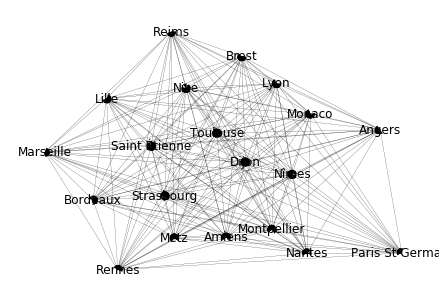

In [903]:
options = {
    'k':1,
    'node_color': 'blue',
    'node_size' : [nx_page_rank.get(n) for n in D.nodes()],
    #'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
    'with_labels':True
}
nx.draw_spring(D, **options)
plt.show()

#nx.draw_spring(D, k =1,  \
#               node_size = [nx_page_rank.get(n) for n in D.nodes()], 
#               font_size = 6, with_labels = True)

In [887]:
Dh=nx.DiGraph()
Dh.add_weighted_edges_from(result)

# print (nx.pagerank(D))
nx_page_rank_hits = nx.hits(D, normalized=True)

print("Page rank of each page\n")
for w in sorted(nx_page_rank_hits[0], key=nx_page_rank_hits[0].get, reverse=False):
    print(w, np.round(nx_page_rank_hits[0][w],5) )


Page rank of each page

Paris St Germain 0.01791
Marseille 0.02925
Rennes 0.03328
Reims 0.03977
Lille 0.04171
Angers 0.04427
Monaco 0.04474
Nantes 0.04618
Bordeaux 0.05207
Lyon 0.05237
Brest 0.05359
Metz 0.05391
Nice 0.05467
Amiens 0.05605
Strasbourg 0.05616
Montpellier 0.05622
Saint Étienne 0.06099
Dijon 0.06393
Nîmes 0.06452
Toulouse 0.07842


In [889]:
print("Page rank of each page\n")
for w in sorted(nx_page_rank_hits[1], key=nx_page_rank_hits[1].get, reverse=True):
    print(w, np.round(nx_page_rank_hits[1][w],5) )

Page rank of each page

Paris St Germain 0.08266
Lille 0.06349
Rennes 0.06195
Montpellier 0.06193
Marseille 0.05944
Angers 0.05704
Monaco 0.05516
Nantes 0.05395
Lyon 0.05121
Strasbourg 0.04795
Reims 0.04663
Bordeaux 0.04609
Nice 0.04608
Brest 0.04443
Saint Étienne 0.0439
Nîmes 0.0403
Dijon 0.03992
Metz 0.03883
Amiens 0.03459
Toulouse 0.02444


In [906]:

Dk=nx.DiGraph()
Dk.add_weighted_edges_from(result)

# print (nx.pagerank(D))
nx_page_rank_katz = nx.katz_centrality(D, alpha =0.01, beta=1, normalized=False, weight='weight')

print("Page rank of each page\n")
for w in sorted(nx_page_rank_katz, key=nx_page_rank_katz.get, reverse=True):
    print(w, np.round(nx_page_rank_katz[w],5) )
    

Page rank of each page

Paris St Germain 1.38966
Rennes 1.29712
Lille 1.2935
Montpellier 1.27681
Marseille 1.27128
Monaco 1.26975
Nantes 1.2543
Reims 1.25107
Angers 1.24527
Lyon 1.22971
Dijon 1.22835
Nice 1.22112
Strasbourg 1.21901
Bordeaux 1.20951
Brest 1.20879
Saint Étienne 1.20137
Nîmes 1.19143
Amiens 1.18824
Metz 1.18611
Toulouse 1.11357


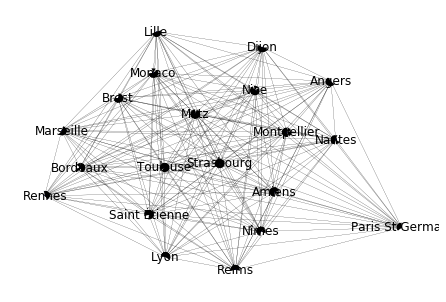

In [907]:
options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
nx.draw(Dk, **options)
plt.show()

In [671]:
G = nx.DiGraph()
graph = nx.from_pandas_edgelist(new_grph, 'source', 'target', 'weight')

gph = nx.to_numpy_matrix(graph)
nx_page_rank = nx.pagerank_numpy(graph,alpha=0.9, weight='weight')

In [672]:
print("Page rank of each page\n")
for w in sorted(nx_page_rank, key=nx_page_rank.get, reverse=False):
    print(w, np.round(nx_page_rank[w],5) )

Page rank of each page

Lyon 0.03682
Rennes 0.04219
Reims 0.04327
Dijon 0.04583
Saint Étienne 0.04591
Nîmes 0.04623
Paris St Germain 0.04659
Bordeaux 0.04922
Toulouse 0.04997
Metz 0.05028
Monaco 0.05092
Marseille 0.05093
Amiens 0.05145
Montpellier 0.05251
Nantes 0.05254
Angers 0.05457
Strasbourg 0.0552
Brest 0.0569
Nice 0.0574
Lille 0.06127


In [639]:
nx_page_rank

{'Monaco': 0.05223780402058335,
 'Lyon': 0.03577024190518944,
 'Angers': 0.0547652962099179,
 'Bordeaux': 0.050348740063956766,
 'Brest': 0.05904536403183467,
 'Toulouse': 0.04851773632064576,
 'Dijon': 0.045829173862113166,
 'Saint Étienne': 0.04481452481167077,
 'Marseille': 0.05050067989638342,
 'Reims': 0.04481452481167079,
 'Montpellier': 0.052760033788739,
 'Rennes': 0.04192509274416739,
 'Nice': 0.05899385900389343,
 'Amiens': 0.05162586666063816,
 'Lille': 0.0598848959872769,
 'Nantes': 0.05179345609770844,
 'Paris St Germain': 0.0450148841726958,
 'Nîmes': 0.04523944129218594,
 'Strasbourg': 0.055715563975433674,
 'Metz': 0.05040282034329506}

In [364]:
def from_pd_to_graph_for_win(row):
    source = row[3]
    target = row[0]
    weight = 3
    goals = row[1]
    
    if(row[5] == 1):
        source = row[0]
        target = row[3]
        goals = row[2]
        
    if (row[6] == 1):
        weight = 1

    return source, target, weight, goals

def from_pd_to_graph_for_lose(row):
    source = row[0]
    target = row[3]
    weight = 0
    goals = row[2]
    
    if(row[5] == 1):
        source = row[3]
        target = row[0]
        goals = row[1]
        
    if (row[6] == 1):
        weight = 1
        
    return source, target, weight, goals


In [252]:
del graph_df1, graph_df2, graph_ultime
graph_df1 = new_df 
graph_df2 = new_df 


graph_df1[["source", "target", "weight", "score"]] = new_df.apply(lambda x: from_pd_to_graph_for_win(x), axis=1,result_type='expand')
graph_df1 = graph_df1.drop(columns=['Home Team','H Score','A Score','Away Team','home_win','draw','away_win'])

new_df = new_df.drop(columns=["source","target","weight","score"])

graph_df2[["source", "target", "weight", "score"]] = new_df.apply(lambda x: from_pd_to_graph_for_lose(x), axis=1,result_type='expand')
graph_df2 = graph_df2.drop(columns=['Home Team','H Score','A Score','Away Team','home_win','draw','away_win'])
#new_df = new_df.drop(columns=["source","target","weight","score"])

graph_ultime = graph_df1.append(graph_df2, ignore_index=True).dropna()



In [197]:
graph_ultime['score']  = graph_ultime.groupby(['source', 'target'])['score'].transform('sum')
graph_ultime['weight'] = graph_ultime.groupby(['source', 'target'])['weight'].transform('sum')

In [236]:
graph_ultime[graph_ultime['source'] == 'Paris St Germain']['score'].sum()

24.0

In [254]:
graph_ultime.head()

,source,target,weight,score
0,Monaco,Lyon,3,3.0
1,Bordeaux,Angers,3,3.0
2,Toulouse,Brest,1,1.0
3,Dijon,Saint Étienne,3,2.0
4,Marseille,Reims,3,2.0


In [246]:
graph_ultime.groupby(['source']).describe()

weight                                              score  \
                  count      mean       std  min  25%  50%  75%  max count   
source                                                                       
Amiens             27.0  1.814815  1.210119  0.0  1.0  1.0  3.0  3.0  27.0   
Angers             27.0  1.444444  1.368136  0.0  0.0  1.0  3.0  3.0  27.0   
Bordeaux           27.0  1.333333  1.270978  0.0  0.0  1.0  3.0  3.0  27.0   
Brest              27.0  1.370370  1.244933  0.0  0.0  1.0  3.0  3.0  27.0   
Dijon              27.0  1.666667  1.270978  0.0  1.0  1.0  3.0  3.0  27.0   
Lille              27.0  1.148148  1.378508  0.0  0.0  0.0  3.0  3.0  27.0   
Lyon               27.0  1.259259  1.318291  0.0  0.0  1.0  3.0  3.0  27.0   
Marseille          27.0  0.703704  1.067521  0.0  0.0  0.0  1.0  3.0  27.0   
Metz               27.0  1.481481  1.251779  0.0  0.5  1.0  3.0  3.0  27.0   
Monaco             27.0  1.259259  1.318291  0.0  0.0  1.0  3.0  3.0  27.0   
Montpellier        27.0  1.259259  1.318291  0.0  0.0  1.0  3.0  3.0  27.0   
Nantes             27.0  1.481481  1.424251  0.0  0.0  1.0  3.0  3.0  27.0   
Nice               27.0  1.296296  1.295401  0.0  0.0  1.0  3.0  3.0  27.0   
Nîmes              27.0  1.777778  1.339728  0.0  0.5  3.0  3.0  3.0  27.0   
Paris St Germain   27.0  0.407407  0.971092  0.0  0.0  0.0  0.0  3.0  27.0   
Reims              27.0  1.185185  1.177907  0.0  0.0  1.0  2.0  3.0  27.0   
Rennes             27.0  1.074074  1.327981  0.0  0.0  0.0  3.0  3.0  27.0   
Saint Étienne      27.0  1.740741  1.375405  0.0  0.0  3.0  3.0  3.0  27.0   
Strasbourg         27.0  1.407407  1.393923  0.0  0.0  1.0  3.0  3.0  27.0   
Toulouse           27.0  2.370370  1.114525  0.0  2.0  3.0  3.0  3.0  27.0   

                                                               
                      mean       std  min  25%  50%  75%  max  
source                                                         
Amiens            1.777778  1.310705  0.0  1.0  2.0  2.5  4.0  
Angers            1.222222  1.527525  0.0  0.0  1.0  2.0  6.0  
Bordeaux          1.222222  1.050031  0.0  1.0  1.0  1.5  4.0  
Brest             1.333333  1.208941  0.0  0.0  1.0  2.0  4.0  
Dijon             1.333333  1.000000  0.0  1.0  1.0  2.0  4.0  
Lille             1.000000  1.143544  0.0  0.0  1.0  2.0  5.0  
Lyon              0.962963  0.939782  0.0  0.0  1.0  1.0  4.0  
Marseille         1.000000  1.143544  0.0  0.0  1.0  1.0  4.0  
Metz              1.259259  1.059484  0.0  0.0  1.0  2.0  4.0  
Monaco            1.555556  1.310705  0.0  0.5  1.0  3.0  4.0  
Montpellier       1.074074  1.106829  0.0  0.0  1.0  1.0  5.0  
Nantes            1.074074  1.035000  0.0  0.0  1.0  2.0  3.0  
Nice              1.370370  1.079464  0.0  1.0  1.0  2.0  4.0  
Nîmes             1.555556  1.502135  0.0  0.5  1.0  2.0  6.0  
Paris St Germain  0.888889  1.154701  0.0  0.0  0.0  1.5  4.0  
Reims             0.777778  0.800641  0.0  0.0  1.0  1.0  3.0  
Rennes            0.888889  0.800641  0.0  0.0  1.0  1.0  3.0  
Saint Étienne     1.629630  1.181529  0.0  1.0  2.0  2.0  4.0  
Strasbourg        1.185185  1.144789  0.0  0.0  1.0  2.0  5.0  
Toulouse          2.074074  1.268734  0.0  1.0  2.0  3.0  5.0

In [178]:
for team in teams : 
    graph_ultime = graph_ultime.append({'source':team,'target':team,'weight':20,'score':0},ignore_index=True)

In [228]:
graph_ultime

,source,target,weight,score
0,Monaco,Lyon,3,3.0
1,Bordeaux,Angers,3,3.0
2,Toulouse,Brest,1,1.0
3,Dijon,Saint Étienne,3,2.0
4,Marseille,Reims,3,2.0
...,...,...,...,...
535,Paris St Germain,Dijon,0,0.0
536,Rennes,Toulouse,0,0.0
537,Bordeaux,Nice,1,1.0
538,Lyon,Saint Étienne,0,0.0


In [443]:
del graph, nx_page_rank

graph = nx.from_pandas_edgelist(new_grph, 'source', 'target', 'weight')

nx_page_rank = nx.pagerank(graph, alpha=1)

In [444]:
print("Page rank of each page\n")
for w in sorted(nx_page_rank, key=nx_page_rank.get, reverse=False):
    print(w, np.round(nx_page_rank[w],5) )

Page rank of each page

Lyon 0.03636
Rennes 0.04288
Saint Étienne 0.04464
Nîmes 0.04498
Reims 0.04536
Dijon 0.04557
Paris St Germain 0.04646
Toulouse 0.04743
Metz 0.05001
Bordeaux 0.05033
Marseille 0.05101
Amiens 0.0511
Nantes 0.05186
Monaco 0.05235
Montpellier 0.05283
Angers 0.0547
Strasbourg 0.05538
Nice 0.05854
Brest 0.05855
Lille 0.05966


In [441]:
graph = nx.from_pandas_edgelist(new_grph, 'source', 'target', 'weight')

nx_page_rank = nx.pagerank(graph,alpha=1)

In [442]:
print("Page rank of each page\n")
for w in sorted(nx_page_rank, key=nx_page_rank.get, reverse=False):
    print(w, np.round(nx_page_rank[w],2) )

Page rank of each page

Lyon 0.04
Rennes 0.04
Saint Étienne 0.04
Nîmes 0.04
Reims 0.05
Dijon 0.05
Paris St Germain 0.05
Toulouse 0.05
Metz 0.05
Bordeaux 0.05
Marseille 0.05
Amiens 0.05
Nantes 0.05
Monaco 0.05
Montpellier 0.05
Angers 0.05
Strasbourg 0.06
Nice 0.06
Brest 0.06
Lille 0.06


In [74]:
graph.get_edge_data('Marseille','Toulouse')

{'weight': 0, 'score': 0.0}

In [75]:
print(graph['Marseille'])

{'Reims': {'weight': 0, 'score': 2.0}, 'Nantes': {'weight': 1, 'score': 3.0}, 'Nice': {'weight': 0, 'score': 2.0}, 'Saint Étienne': {'weight': 0, 'score': 3.0}, 'Monaco': {'weight': 0, 'score': 4.0}, 'Montpellier': {'weight': 1, 'score': 1.0}, 'Dijon': {'weight': 1, 'score': 0.0}, 'Rennes': {'weight': 1, 'score': 2.0}, 'Amiens': {'weight': 0, 'score': 1.0}, 'Strasbourg': {'weight': 0, 'score': 0.0}, 'Paris St Germain': {'weight': 0, 'score': 0.0}, 'Lille': {'weight': 0, 'score': 4.0}, 'Lyon': {'weight': 0, 'score': 1.0}, 'Toulouse': {'weight': 0, 'score': 0.0}, 'Brest': {'weight': 0, 'score': 1.0}, 'Angers': {'weight': 1, 'score': 0.0}, 'Bordeaux': {'weight': 1, 'score': 3.0}, 'Metz': {'weight': 1, 'score': 1.0}, 'Nîmes': {'weight': 0, 'score': 6.0}}
